# 1. Environment setup and data loading:

   Year      TA01      TA02      TA03      TA04      TA05      TA06      TA07  \
0  2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905 -25.01202   
1  2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   8.76630   
2  2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940  -3.27872   
3  2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   5.05097   
4  2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409 -12.48207   

       TA08      TA09  ...      TC69       TC70      TC71      TC72      TC73  \
0 -12.23257   7.83089  ...  13.01620  -54.40548  58.99367  15.37344   1.11144   
1  -0.92019  18.76548  ...   5.66812  -19.68073  33.04964  42.87836  -9.90378   
2  -2.35035  16.07017  ...   3.03800   26.05866 -50.92779  10.93792  -0.07568   
3 -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705 -46.67617 -12.51516   
4  -9.37636  12.63699  ...   9.92661  -55.95724  64.92712 -17.72522  -1.49237   

       TC74       TC75    

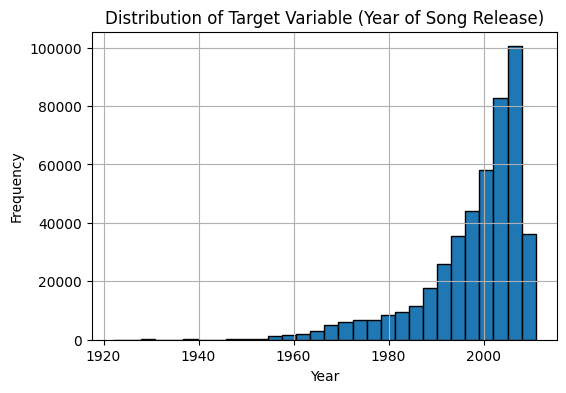

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Step 1: Load the dataset
data = pd.read_csv('Training_set_songs.csv', header=0)

# Quick check
print(data.head())

# Step 2: Separate target and features
y = data.iloc[:, 0].values  # First column: year
y = y.astype(int)
X = data.iloc[:, 1:].values  # Rest: 90 features

print(f"Dataset shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Step 3: 95/05 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


print("\nFeature summary statistics ")
print(pd.DataFrame(X_train).describe())

# Target distribution
plt.figure(figsize=(6,4))
plt.hist(y, bins=30, edgecolor='black')
plt.title('Distribution of Target Variable (Year of Song Release)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



# 2. Kernel Ridge Regression implementation: 

In [2]:
class KernelRidgeRegression:
    def __init__(self, lambda_reg=1e-3, degree=4, coef0=1):
        self.lambda_reg = lambda_reg
        self.degree = degree
        self.coef0 = coef0
        self.X_train = None
        self.alpha = None

    def fit(self, X, y):
        """
        Fit the Kernel Ridge Regression model using a Polynomial kernel.

        Args:
            X: (n_samples, n_features) - Training data
            y: (n_samples,) - Target values
        """
        n_samples = X.shape[0]
        K = polynomial_kernel(X, X, degree=self.degree, coef0=self.coef0)
        # Solve (K + n * lambda * I) alpha = y
        self.alpha = np.linalg.solve(K + n_samples * self.lambda_reg * np.eye(n_samples), y)
        self.X_train = X

    def predict(self, X):
        """
        Predict using the trained model.

        Args:
            X: (n_samples, n_features) - Test data

        Returns:
            y_pred: (n_samples,) - Predicted target values
        """
        K_test = polynomial_kernel(X, self.X_train, degree=self.degree, coef0=self.coef0)
        return np.dot(K_test, self.alpha)

def polynomial_kernel(X, Y, degree=4, coef0=1):
    """
    Compute the Polynomial kernel between two datasets.

    Args:
        X: (n_samples_X, n_features)
        Y: (n_samples_Y, n_features)
        degree: Degree of the polynomial kernel (e.g., 4)
        coef0: Independent term in the kernel function (e.g., 1)

    Returns:
        Kernel matrix (n_samples_X, n_samples_Y)
    """
    return (np.dot(X, Y.T) + coef0) ** degree


# 3. Baseline comparison:

In [3]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Initialize Ridge Regression (baseline)
baseline_model = Ridge(alpha=1.0)  # alpha = regularization strength

# Fit baseline model
baseline_model.fit(X_train, y_train)

# Predict on test set
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Baseline Ridge Regression Test MSE: {mse_baseline:.4f}")
print(f"Baseline Ridge Regression Test R^2 Score: {r2_baseline:.4f}")


Baseline Ridge Regression Test MSE: 93.1450
Baseline Ridge Regression Test R^2 Score: 0.2375


# 4. Hyperparameter tuning:

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def grid_search_krr(X, y, lambdas, degrees, cv_folds=5):
    """
    Grid search to find the best (lambda, degree) for Kernel Ridge Regression with Polynomial Kernel.

    Args:
        X: (n_samples, n_features) - Training data
        y: (n_samples,) - Target values
        lambdas: list of candidate regularization parameters
        degrees: list of candidate polynomial degrees
        cv_folds: number of folds in cross-validation

    Returns:
        best_lambda: Best regularization parameter
        best_degree: Best polynomial degree
        best_score: Best average validation MSE
    """
    best_score = float('inf')
    best_lambda = None
    best_degree = None

    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for lam in lambdas:
        for degree in degrees:
            val_scores = []

            for train_index, val_index in kf.split(X):
                X_train_fold, X_val_fold = X[train_index], X[val_index]
                y_train_fold, y_val_fold = y[train_index], y[val_index]

                model = KernelRidgeRegression(lambda_reg=lam, degree=degree, coef0=1)
                model.fit(X_train_fold, y_train_fold)
                y_pred_val = model.predict(X_val_fold)
                mse = mean_squared_error(y_val_fold, y_pred_val)
                val_scores.append(mse)

            avg_score = np.mean(val_scores)

            if avg_score < best_score:
                best_score = avg_score
                best_lambda = lam
                best_degree = degree

    return best_lambda, best_degree, best_score


In [24]:
# Define search grid
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1]
degrees = [2, 3, 4, 5, 6]  # Reasonable polynomial degrees to try

# Subsample 5000 points for grid search ONLY (to make it fast)
np.random.seed(42)
subset_indices = np.random.choice(X_train.shape[0], size=5000, replace=False)
X_train_subset = X_train[subset_indices]
y_train_subset = y_train[subset_indices]

# Run grid search
best_lambda, best_degree, best_val_mse = grid_search_krr(X_train_subset, y_train_subset, lambdas, degrees)

print(f"Best lambda: {best_lambda}")
print(f"Best degree: {best_degree}")
print(f"Best validation MSE (subset): {best_val_mse:.4f}")


Best lambda: 1
Best degree: 2
Best validation MSE (subset): 19677201.3957


# 5. Model training and testing: 

In [11]:
# 1. Subsample 10,000 training points from the full original data (463k)
subset_indices = np.random.choice(X.shape[0], size=10000, replace=False)
X_train_50k = X[subset_indices]
y_train_50k = y[subset_indices]

print(f"Subsampled training set: {X_train_50k.shape}, Target: {y_train_50k.shape}")



# 3. Train the final model on the 10,000 points
final_model = KernelRidgeRegression(lambda_reg=1, degree=2)
final_model.fit(X_train_50k, y_train_50k)

# 4. Predict on the original test set (not re-split!)
y_pred_test = final_model.predict(X_test)

# 5. Evaluate performance
from sklearn.metrics import mean_squared_error, r2_score

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Final Test MSE (trained on 10k): {mse_test:.4f}")
print(f"Final Test R² Score (trained on 10k): {r2_test:.4f}")



Subsampled training set: (10000, 90), Target: (10000,)
Final Test MSE (trained on 10k): 22911.9143
Final Test R² Score (trained on 10k): -186.5633


# Using the Divide and Conquer paper 

In [15]:
def split_data(X, y, m):
    """Split X and y into m roughly equal subsets."""
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
    splits_X = np.array_split(X[indices], m)
    splits_y = np.array_split(y[indices], m)
    return splits_X, splits_y

m = 44
splits_X, splits_y = split_data(X_train, y_train, m)

print(f"Split into {m} subsets, each subset has around {len(splits_X[0])} samples.")


Split into 44 subsets, each subset has around 10013 samples.


In [16]:
# Fixed hyperparameters for Polynomial Kernel
fixed_lambda = 1
fixed_degree = 2  # 2nd degree polynomial
fixed_coef0 = 1

models = []

# Train one KRR model per subset
for i in range(m):
    model = KernelRidgeRegression(lambda_reg=fixed_lambda, degree=fixed_degree, coef0=fixed_coef0)
    model.fit(splits_X[i], splits_y[i])
    models.append(model)
    
    if (i+1) % 10 == 0:
        print(f"Trained model {i+1}/{m}")

# ------------------------
# Prediction Phase
import time

predictions = []

total_models = len(models)

for idx, model in enumerate(models):
    start_time = time.time()
    
    y_pred = model.predict(X_test)
    predictions.append(y_pred)
    
    elapsed = time.time() - start_time
    print(f"Model {idx+1}/{total_models} prediction done. Time taken: {elapsed:.2f} seconds.")

# Stack and average predictions
predictions = np.vstack(predictions)
y_pred_avg = np.mean(predictions, axis=0)

# ------------------------
# Evaluation Phase
from sklearn.metrics import mean_squared_error, r2_score

mse_test = mean_squared_error(y_test, y_pred_avg)
r2_test = r2_score(y_test, y_pred_avg)

print(f"Final Test MSE (Divide-and-Conquer fixed λ, degree): {mse_test:.4f}")
print(f"Final Test R² Score (Divide-and-Conquer fixed λ, degree): {r2_test:.4f}")


Trained model 10/44
Trained model 20/44
Trained model 30/44
Trained model 40/44
Model 1/44 prediction done. Time taken: 0.51 seconds.
Model 2/44 prediction done. Time taken: 0.45 seconds.
Model 3/44 prediction done. Time taken: 0.43 seconds.
Model 4/44 prediction done. Time taken: 0.44 seconds.
Model 5/44 prediction done. Time taken: 0.47 seconds.
Model 6/44 prediction done. Time taken: 0.45 seconds.
Model 7/44 prediction done. Time taken: 0.54 seconds.
Model 8/44 prediction done. Time taken: 0.49 seconds.
Model 9/44 prediction done. Time taken: 0.48 seconds.
Model 10/44 prediction done. Time taken: 0.48 seconds.
Model 11/44 prediction done. Time taken: 0.52 seconds.
Model 12/44 prediction done. Time taken: 0.51 seconds.
Model 13/44 prediction done. Time taken: 0.52 seconds.
Model 14/44 prediction done. Time taken: 0.54 seconds.
Model 15/44 prediction done. Time taken: 0.47 seconds.
Model 16/44 prediction done. Time taken: 0.50 seconds.
Model 17/44 prediction done. Time taken: 0.47 sec